In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter

In [3]:
connectivity_min, connectivity_max = 0,130
delay_min, delay_max = 0,2
random_input_span = (1.2,2.8)
# random_input_span = (9.5,13.5)
total_time = 1000
alpha = 20
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational','Non_repulsive_rotational']
neuron_model = current_models[0]

model_folder_name = neuron_model+'_ensembles'
# version = '_v1.0'
version = '_cluster_computed'

# Capture related ensembles

In [4]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [5]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1]) + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [6]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [7]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    if g > connectivity_max or g < connectivity_min: continue #check if this connectivity is requested
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        if delay > delay_max or delay < delay_min: continue #check if this connectivity is requested
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model in ['Rotational','Non_repulsive_rotational']: #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(np.abs( field_period_glossary_dict[g][delay] ) )
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model in ['Rotational','Non_repulsive_rotational']:amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [8]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    return table

def create_contour_phase_space(dataframe, title):
    fig = plt.figure()
    ax = fig.add_subplot()

    dataframe_filtered = median_filter(dataframe, size=20)
    contours = ax.contourf(dataframe_filtered, cmap = 'inferno')

    C = ax.contour(dataframe_filtered, colors='black', linewidth=.5)
    ax.clabel(C, inline=1, fontsize=10)


    yticklabels = ['{:.2f}'.format(x) for x in dataframe.index.to_list()]
    xticklabels = ['{:.1f}'.format(x) for x in dataframe.columns.to_list()]

    ax.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))
    ax.xaxis.set_major_formatter(ticker.IndexFormatter(xticklabels))
    
    ax.set_title('{} phase space (with median filter)'.format(title))
    ax.set_xlabel('Connectivity')
    ax.set_ylabel('Delay (s)')
    plt.close()
    return fig

In [9]:
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

# Sigma dataframe

In [10]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table.head()

connectivity,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.2,7.3
delay,,,,,,,,,,,,,,,,,,,,,
0.00,0.194733,0.196030,0.197391,0.197671,0.196815,0.197556,0.197610,0.196940,0.199123,0.198090,...,0.195818,0.195486,0.195365,0.197133,0.197258,0.197201,0.198434,0.195953,0.197483,0.198805
0.02,0.196922,0.081055,0.054139,0.041797,0.033882,0.028854,0.025227,0.023327,0.022968,0.022955,...,0.032166,0.033503,0.033065,0.033592,0.033210,0.032539,0.034094,0.033095,0.033636,0.034004
0.04,0.197160,0.083157,0.056442,0.044904,0.037014,0.032028,0.030278,0.032791,0.037480,0.043821,...,0.084747,0.084950,0.084046,0.087102,0.087938,0.087937,0.087312,0.087006,0.086924,0.087868
0.06,0.196285,0.087947,0.059528,0.046768,0.040156,0.036652,0.040564,0.050515,0.067105,0.079718,...,0.141452,0.137383,0.135476,0.139713,0.137333,0.137734,0.138114,0.137143,0.141284,0.138900
0.08,0.197278,0.088655,0.062038,0.050373,0.044006,0.041252,0.048606,0.070272,0.093644,0.114639,...,0.186135,0.187502,0.182479,0.184002,0.189027,0.181649,0.183996,0.184244,0.184379,0.183454


C:\Users\mohsen\AppData\Local\Temp/ipykernel_15588/2442720307.py:7: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))


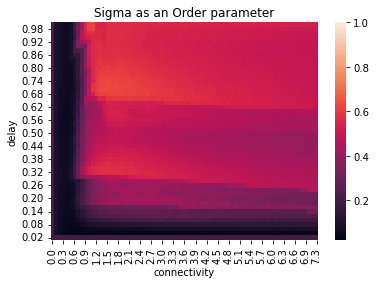

In [11]:
yticklabels = ['{:.2f}'.format(x) for x in sigma_table.index.to_list()]
ax_sigma = sns.heatmap(sigma_table, annot=False, vmax = 1)

ax_sigma.set_title('Sigma as an Order parameter')
ax_sigma.invert_yaxis()

ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))

In [12]:
fig = ax_sigma.get_figure()
fig.savefig(os.path.join(target_path, 'sigma_phase_space.png'), dpi = 1000)

In [20]:
create_contour_phase_space(sigma_table, r'$\sigma$').savefig(os.path.join(target_path, 'sigma_phase_space_contour.png'), dpi = 1000)

C:\Users\mohsen\AppData\Local\Temp/ipykernel_15588/1626521888.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(dataframe_filtered, colors='black', linewidth=.5)
C:\Users\mohsen\AppData\Local\Temp/ipykernel_15588/1626521888.py:22: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))
C:\Users\mohsen\AppData\Local\Temp/ipykernel_15588/1626521888.py:23: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax.xaxis.set_major_formatter(ticker.IndexFormatter(xticklabels))


# Amin Saman Parameter

In [14]:
if neuron_model in ['Rotational','Non_repulsive_rotational']:
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')
    fig = ax_field_period.get_figure()
    fig.savefig(os.path.join(target_path, 'amin_saman_phase_space.png'))
    
    create_contour_phase_space(amin_saman_param_table, 'AminSaman')

# Field period dataframe

In [15]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table.head()

connectivity,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.2,7.3
delay,,,,,,,,,,,,,,,,,,,,,
0.00,0.475023,0.475023,0.459982,0.455013,0.455013,0.474969,0.459982,0.455013,0.455013,0.455013,...,0.459982,0.455013,0.455013,0.459982,0.450045,0.450045,0.459982,0.475023,0.459982,0.455013
0.02,0.455013,0.475001,0.504972,0.535038,0.539957,0.569978,0.585008,0.610045,0.330533,0.041684,...,0.110181,0.145164,0.114039,0.223562,0.117143,0.174194,0.154656,0.189133,0.122185,0.166901
0.04,0.455013,0.490038,0.520021,0.520021,0.539957,0.569978,0.580046,0.083294,0.083400,0.083897,...,0.155600,0.235888,0.156925,0.159249,0.161486,0.161474,0.162604,0.163214,0.166154,0.167413
0.06,0.455013,0.494973,0.500000,0.545006,0.339977,0.139997,0.121090,0.123890,0.124156,0.126695,...,0.233323,0.233520,0.234443,0.237220,0.241083,0.240704,0.242200,0.244987,0.248760,0.250109
0.08,0.455013,0.485016,0.500000,0.529989,0.369948,0.374985,0.163080,0.162523,0.165369,0.165989,...,0.310662,0.314027,0.314565,0.317058,0.319298,0.320308,0.324625,0.327398,0.326014,0.330472


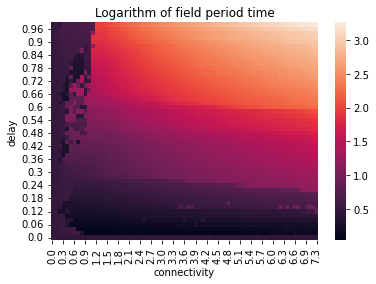

In [16]:
# ax_field_period = sns.heatmap(np.log(field_period_table.abs()), annot=False, vmax = 2, vmin = -2)
ax_field_period = sns.heatmap(field_period_table.abs(), annot=False)
ax_field_period.set_title('Logarithm of field period time')
ax_field_period.invert_yaxis()

In [17]:
fig = ax_field_period.get_figure()
fig.savefig(os.path.join(target_path, 'field_period_phase_space.png'))

C:\Users\mohsen\AppData\Local\Temp/ipykernel_15588/1626521888.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(dataframe_filtered, colors='black', linewidth=.5)
C:\Users\mohsen\AppData\Local\Temp/ipykernel_15588/1626521888.py:22: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))
C:\Users\mohsen\AppData\Local\Temp/ipykernel_15588/1626521888.py:23: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax.xaxis.set_major_formatter(ticker.IndexFormatter(xticklabels))


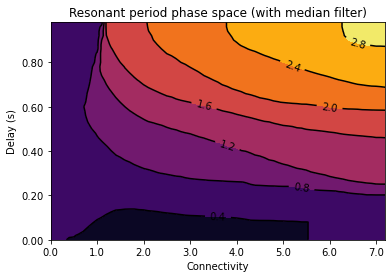

In [19]:
create_contour_phase_space(field_period_table.abs(), 'Resonant period')

In [ ]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table.head()

In [ ]:
create_contour_phase_space(max_intensity_table, 'intensity of MaxFreq.')

In [ ]:
# %matplotlib notebook
# from mpl_toolkits.mplot3d import Axes3D

# d_arr = max_intensity_table.index
# g_arr = max_intensity_table.columns
# bars_pos = np.array([np.tile(g_arr, len(d_arr)), np.repeat(d_arr, len(g_arr)), [0]*(len(d_arr)*len(g_arr))])

# dd_arr = d_arr[1] - d_arr[0]
# dg_arr = g_arr[1] - g_arr[0]

# dmax_intensity = max_intensity_table.to_numpy().flatten()

# cmap = plt.cm.get_cmap('magma') # Get desired colormap - you can change this!
# period_arr = field_period_table.to_numpy().flatten()
# max_height = np.max(period_arr)   # get range of colorbars so we can normalize
# min_height = np.min(period_arr)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap( np.log( k ) ) for k in period_arr] 


# fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
# # ax = fig.add_subplot(111, projection='3d')
# # ax.bar3d(bars_pos[0], bars_pos[1], bars_pos[2], dg_arr, dd_arr, dmax_intensity, color=rgba)